# INFO 2950 Project Phase II

Tina Chen (tc663), Catherine Fang (cf533), Vicki Chen (vc332)

## **Background and Research Questions**

** Note: In this document, the phrases, 'Kickstarter campaign' and 'Kickstarter project' are used interchangeably.

Kickstarter is a crowdfunding website that allows creators to create fundraising campaigns to fund startups, products, and projects to help them become a reality. Kickstarter campaigns have many factors that can influnce how likely they are to successfully reach their target fundraising goal. These factors include category of the project, location the project is based in, original currency of the camapaign, and number of backers. The focus of our research is to examine the factors that lead to a project being successful to identify any predictors of project success, and determine which factors are the best predictors of a project's success. 

The Kickstarter Public Data Dataset we are using has a combination of the publicly available information on past successful and unsuccessful kickstarter project. The Kickstarter Backers Dataset contains information about the backers of each project. 

Research Question: Are there any relationships between the predictors (category of project, location, currency, number of backers) of success and the success of a Kickstarter project?
- What is the relationship between the category of the campaign and the average campaign goals for each category, by success vs failed projects? Are the two correlated with one another, and which influence success more? 
  - Which category has the highest number of successful campaigns?
- What is the relationship between the project goal and the number of backers of a successful project? Does higher project goals lead to higher number of backers of a successful project?
- How does the length of a project impact the amount of money raised, regardless of whether or not its successful?
- How do Kickstarter project success rates compare for US vs Non-US based projects? (in progress)
- How do projects' success rates compare considering the projects' orignal currencies? 
- WHich year has the most projects that were successful?
- Based on the surplus (difference between pledged and goal amount), what is the success rate?

## **Data Description**

### Raw Dataset Description

The attributes (columns) of the clean dataset are the PID (Project ID), Category (numbers indicating what topic the project falls under), Subcategory (numbers indicating the subtopics within each category), the Project Location Name, State, County, and Country. Other relevant attributes included are the Project Currency, the Project’s Original Goal (how much money the creators were aiming for), amount of money pledged, the number of backers, the launched date, deadline date, and state. State is defined as either suspended (funding for a project is stopped when the project violates Kickstarter’s rules), canceled (the creators of a project dropped the project themselves), failed (the project didn’t meet funding goals), and successful (project meets funding goals). Each observation (row) corresponds to one unique project, indexed with a CaseID.

The raw dataset was created by Jonathan Leland, Kickstarter’s Head of Insights for a cross-sectional study on the different creative projects that seek crowdfunding. He created the dataset to observe data on the projects from Kickstarter. 

The creation of this dataset is funded by Kickstarter Data, the company crowdfunding platform that directs the Kickstarter Project. The study is distributed through the Inter-University Consortium for Political and Social Research (ICPSR). 

Some columns were presented as optional for users to fill out, so in the raw data there are some rows with missing values. For example, for the PROJECT_LOCATION_STATE, PROJECT_LOCATION_COUNTY, PROJECT_LOCATION_COUNTRY column, there are rows with blank values. However, there are no missing values in the PROJECT_LOCATION_NAME, meaning that the project creators were required to put down the location name for their project. 

ICPSR processed the data by creating variable/value labels, creating an online analysis version with question text, and 
checked the data for undocumented or out-of-range codes. In addition, several restrictions were placed on the data before releasing it for public use to ensure survey participant anonymity. The data was split into a public-use file, a restricted-use file, and file containing information on the backers of projects. 

ICPSR datasets are checked for condidentiality of survey participants. The names of the people/groups who created past Kickstarter projects (NAME) and the links to their projects’ websites (URL_NAME), and the descriptions of their projects (BLURB) are not shown in the public data set that was used as the raw dataset for this project. This ensures anonymity of survey participants and prevents disclosure risk from survey participants.

Raw Data was collected by downloading the delimited data from the study at this link, https://www.icpsr.umich.edu/web/ICPSR/studies/38050/summary and Git Large Language Storage was used to upload the raw files onto Github. 


### Cleaned Dataset Description

The clean dataset was tailored according to our research questions. We dropped redacted information (NAME, PROJECT_PAGE_LOCATION_COUNTRY, URL_NAME) and other attributes we did not need to answer our research question ("SUBCATEGORY", "UID", "PROJECT_PAGE_LOCATION_STATE", "PROJECT_PAGE_LOCATION_COUNTY").

We kept the CASEID, PID, Category, PROJECT_PAGE_LOCATION_NAME, PROJECT_CURRENCY, GOAL_IN_ORIGINAL_CURRENCY, PLEDGED_IN_ORIGINAL_CURRENCY, GOAL_IN_USD, PLEDGED_IN_USD, BACKERS_COUNT, LAUNCHED_DATE, DEADLINE_DATE, and STATE attributes since we directly need them to find relationships between their impact on the STATE (success or failure of the project).

This version of the clean dataset was created by Tina Chen (tc663), Catherine Fang (cf533), and Vicki Chen (vc332) to find any predictors of a Kickstarter project's success and gain insights from past Kickstarter projects to help future Kickstarter campaigns succeed and avoid any predictors of failure.  

The creation of this dataset was not funded.

Since the raw dataset was created from survey data and survey participants were from a wide variety of countries with many different languages, the survey's collected data may be subject to participant error, misinterpretations, and language barriers. In addition, only the public dataset was available for public download, and thus, the NAME, PROJECT_PAGE_LOCATION_COUNTRY, and URL_NAME were not available and could only be found in the restricted dataset. In addition, since our research question only took into consideration factors for predicting the success and failure of a project, we did not include canceled or suspended projects in our cleaned dataset. 

Preprocessing of the raw dataset was done by Jonathan Leland and distributed by the Inter-University Consortium for Political and Social Research (ICPSR). Details of the preprocessing can be found in the Raw Dataset Description section, found above.

As above, in the raw dataset, the anonymity of survey particpants was preserved during the creation of the raw dataset and we did not attempt to violate their anonymity during the creation of this cleaned dataset. Survey particpants expected the raw dataset to be used for research purposes only, provided their anonymity was not preserved, but we are able to use the publically available dataset since the preprocessing of the public dataset preserved survey particpants' anonymity.

The raw dataset can be found at this link: https://www.icpsr.umich.edu/web/ICPSR/studies/38050/summary 

## **Data Cleaning**

Data Cleaning was done to tailor the data to our research question. 

Data cleaning was done to create a dataset from the raw data for analysis. After opening the original public_data tsv file, we observed that several variables were not available publicly and were only available in the restricted dataset which we did not have access to. These variables include NAME, URL_NAME, and PROJECT_PAGE_LOCATION_COUNTRY. In addition, there were some rows that had missing values, particularly in the PROJECT_PAGE_LOCATION_STATE, and PROJECT_PAGE_LOCATION_COUNTY columns which may indicate that these are user-inputs that are optional. These columns were dropped.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split 
import seaborn as sns
import duckdb
# import datetime

We imported the data and printed out the first 5 rows to view the columns provided by the dataset.

In [2]:
public_data = pd.read_csv('data/public_data.tsv', delimiter='\t')
public_data.head()

C:\Users\lovet\AppData\Local\Temp\ipykernel_5348\4156237419.py:1: DtypeWarning: Columns (9,11,15) have mixed types. Specify dtype option on import or set low_memory=False.
  public_data = pd.read_csv('data/public_data.tsv', delimiter='\t')


,CASEID,NAME,PID,CATEGORY,SUBCATEGORY,PROJECT_PAGE_LOCATION_NAME,PROJECT_PAGE_LOCATION_STATE,PROJECT_PAGE_LOCATION_COUNTY,PROJECT_PAGE_LOCATION_COUNTRY,UID,PROJECT_CURRENCY,GOAL_IN_ORIGINAL_CURRENCY,PLEDGED_IN_ORIGINAL_CURRENCY,GOAL_IN_USD,PLEDGED_IN_USD,BACKERS_COUNT,LAUNCHED_DATE,DEADLINE_DATE,STATE,URL_NAME
0,1,MASKED BY ICPSR,2137925650,11,301,London,England,Greater London,,1076478145,USD,"100,000,000",0,"$100,000,000",$0,0,8/11/2016,10/10/2016,canceled,MASKED BY ICPSR
1,2,MASKED BY ICPSR,1501531085,11,296,Los Angeles,CA,Los Angeles,,224946798,USD,"100,000,000",85,"$100,000,000",$85,4,12/19/2019,2/14/2020,canceled,MASKED BY ICPSR
2,3,MASKED BY ICPSR,953415668,16,51,Mexico,Baja California,Tijuana,,1772203542,MXN,"100,000,000",10,"$5,219,374",$1,1,3/1/2017,3/22/2017,failed,MASKED BY ICPSR
3,4,MASKED BY ICPSR,1371386304,18,18,Columbus,OH,Franklin,,1373465389,USD,"100,000,000",1,"$100,000,000",$1,1,6/4/2018,7/5/2018,canceled,MASKED BY ICPSR
4,5,MASKED BY ICPSR,1720842777,1,22,Toronto,ON,Toronto,,1455666383,CAD,"100,000,000",0,"$80,610,122",$0,0,5/1/2015,6/30/2015,failed,MASKED BY ICPSR


We checked for duplicates in the public_data.tsv dataset by selecting the rows that appeared more than once according to the unique PID. Since there are no rows that appeared more than once, we know that there is no duplicate PIDs in the dataset.

In [3]:
duckdb.sql("SELECT PID, COUNT(PID) FROM public_data GROUP BY PID HAVING COUNT(PID) > 1").df()

,PID,count(PID)


We dropped the following columns: NAME, PROJECT_PAGE_LOCATION_COUNTRY, and URL_NAME since they contained restricted information that wasn't available to the public. We also dropped the PROJECT_PAGE_LOCATION_STATE and PROJECT_PAGE_LOCATION_COUNTY since they were prone to user-input error and it is not plausible to clean all 600,000+ entries manually.

We also dropped the UID, and the rows that are not successful or failed (canceled or suspended). By definition, a canceled project is one that the project leader has stopped voluntarily and a suspended project is one that was taken down by KickStarter moderators for violating their terms of service or other policies.

We chose to drop the canceled and suspended projects since we do not have further information regarding why they were canceled or suspended, since we do not have access to the project's name or url in the public dataset available to us. We could not make use of canceled or suspended projects in our research question either, since cancellations and suspensions of a campaign are subject to individual's decisions and frequently changing Kickstarter terms and conditions/policies which may vary from individual to individual/year to year.

In [4]:
public_data_df = pd.DataFrame(public_data)
clean_data = public_data_df.drop(columns = ["NAME", "SUBCATEGORY", 
"PROJECT_PAGE_LOCATION_COUNTRY", "URL_NAME", "UID", 
"PROJECT_PAGE_LOCATION_STATE", "PROJECT_PAGE_LOCATION_COUNTY"])

clean_data = duckdb.sql("SELECT * FROM clean_data WHERE STATE = 'successful' OR STATE = 'failed'").df()
clean_data.head()

,CASEID,PID,CATEGORY,PROJECT_PAGE_LOCATION_NAME,PROJECT_CURRENCY,GOAL_IN_ORIGINAL_CURRENCY,PLEDGED_IN_ORIGINAL_CURRENCY,GOAL_IN_USD,PLEDGED_IN_USD,BACKERS_COUNT,LAUNCHED_DATE,DEADLINE_DATE,STATE
0,56,128197700,12,Osaka,JPY,"68,000,000","81,030,744","$623,968","$743,538",12613,3/26/2018,5/5/2018,successful
1,63,1900597540,12,Tokyo,JPY,"53,808,516","481,621,841","$510,735","$4,571,420",46307,7/27/2020,8/29/2020,successful
2,83,1012629901,12,Ishikawa,JPY,"45,000,000","98,863,825","$414,327","$910,266",8051,6/3/2019,6/11/2019,successful
3,175,596722349,12,Chiba-shi,JPY,"16,665,000","23,606,140","$148,285","$210,047",1705,9/20/2018,10/20/2018,successful
4,184,2056420743,16,Tokyo,JPY,"15,000,000","17,406,300","$133,229","$154,601",656,10/7/2017,12/6/2017,successful


We also changed all the numerical string values in the dataframe into integers for us to work with. 

In [5]:
clean_data["GOAL_IN_ORIGINAL_CURRENCY"] = clean_data["GOAL_IN_ORIGINAL_CURRENCY"].replace({',': ''}, 
                                                                regex=True).astype(int)
clean_data["PLEDGED_IN_ORIGINAL_CURRENCY"] = clean_data["PLEDGED_IN_ORIGINAL_CURRENCY"].replace({',': ''},
                                                                     regex=True).astype(int)
clean_data["GOAL_IN_USD"] = clean_data["GOAL_IN_USD"].replace({'[\$]': '',',': ''}, 
                                                    regex=True).astype(int)
clean_data["PLEDGED_IN_USD"] = clean_data["PLEDGED_IN_USD"].replace({'[\$]': '',',': ''}, 
                                                            regex=True).astype(int)
clean_data.head()

<>:5: SyntaxWarning: invalid escape sequence '\$'
<>:7: SyntaxWarning: invalid escape sequence '\$'
<>:5: SyntaxWarning: invalid escape sequence '\$'
<>:7: SyntaxWarning: invalid escape sequence '\$'
C:\Users\lovet\AppData\Local\Temp\ipykernel_5348\105191598.py:5: SyntaxWarning: invalid escape sequence '\$'
  clean_data["GOAL_IN_USD"] = clean_data["GOAL_IN_USD"].replace({'[\$]': '',',': ''},
C:\Users\lovet\AppData\Local\Temp\ipykernel_5348\105191598.py:7: SyntaxWarning: invalid escape sequence '\$'
  clean_data["PLEDGED_IN_USD"] = clean_data["PLEDGED_IN_USD"].replace({'[\$]': '',',': ''},


,CASEID,PID,CATEGORY,PROJECT_PAGE_LOCATION_NAME,PROJECT_CURRENCY,GOAL_IN_ORIGINAL_CURRENCY,PLEDGED_IN_ORIGINAL_CURRENCY,GOAL_IN_USD,PLEDGED_IN_USD,BACKERS_COUNT,LAUNCHED_DATE,DEADLINE_DATE,STATE
0,56,128197700,12,Osaka,JPY,68000000,81030744,623968,743538,12613,3/26/2018,5/5/2018,successful
1,63,1900597540,12,Tokyo,JPY,53808516,481621841,510735,4571420,46307,7/27/2020,8/29/2020,successful
2,83,1012629901,12,Ishikawa,JPY,45000000,98863825,414327,910266,8051,6/3/2019,6/11/2019,successful
3,175,596722349,12,Chiba-shi,JPY,16665000,23606140,148285,210047,1705,9/20/2018,10/20/2018,successful
4,184,2056420743,16,Tokyo,JPY,15000000,17406300,133229,154601,656,10/7/2017,12/6/2017,successful


We also checked for NaaN values by checking if there were any rows where the BACKERS_COUNT is null and if it was an empty string. We didn't realize until we started creating scatterplots that there were other inputs like Strings containg a single space that were still lying in our data. 

We also checked for oddities and outliers. For instance, we found rows where the BACKERS_COUNT variable was Null so we cross examined what values the identified rows' PLEDGED_IN_ORIGINAL_CURRENCY columns had to see if the value was 0 or was not 0. If it was 0, then we replaced the NaaN values with 0 since we can assume the number of backers is 0 since no money was pledged by no people. 

*** Need to decide what to do with the NaN values that have non-zero values in their PLEDGED_IN_ORIGINAL_CURRENCY column.

In [6]:
backers_count_null = duckdb.sql("SELECT * FROM clean_data WHERE BACKERS_COUNT IS NULL ").df()
print("The number of rows where BACKERS_COUNT is Null: " + str(len(backers_count_null)))

backers_count_null = duckdb.sql("SELECT * FROM clean_data WHERE BACKERS_COUNT = ''  ").df()
print("The number of rows where BACKERS_COUNT is an Empty String: " + str(len(backers_count_null)))

backers_count_null = duckdb.sql("SELECT * FROM clean_data WHERE BACKERS_COUNT = ' ' ").df()
print("The number of rows where BACKERS_COUNT is a String containing a space: " + str(len(backers_count_null)))

clean_data = duckdb.sql("SELECT * FROM clean_data WHERE NOT BACKERS_COUNT = ' '").df()
print("Cleaned the rows that contained a String with a single space")

backers_count_null = duckdb.sql("SELECT * FROM clean_data WHERE BACKERS_COUNT = ' ' ").df()
print("The number of rows where BACKERS_COUNT is a String containing a space: " + str(len(backers_count_null)))
clean_data["BACKERS_COUNT"] = clean_data["BACKERS_COUNT"].astype(int)

The number of rows where BACKERS_COUNT is Null: 0
The number of rows where BACKERS_COUNT is an Empty String: 0
The number of rows where BACKERS_COUNT is a String containing a space: 56
Cleaned the rows that contained a String with a single space
The number of rows where BACKERS_COUNT is a String containing a space: 0


We converted the LAUNCHED_DATE and DEADLINE_DATE to datetime objects so we could do math with the two dates to get the length of each campaign.

We then calculated the difference between the DEADLINE_DATE and LAUNCHED_DATE to get the in days that each project fundraiser ran for and added it as a new column to the clean_data. 

In [7]:
clean_data['LAUNCHED_DATE'] = pd.to_datetime(clean_data['LAUNCHED_DATE'], format = 'mixed')
clean_data['DEADLINE_DATE'] = pd.to_datetime(clean_data['DEADLINE_DATE'], format = 'mixed')

clean_data['time_difference_days'] = (clean_data['DEADLINE_DATE'] 
                                      - clean_data['LAUNCHED_DATE']).dt.days
clean_data.head()

,CASEID,PID,CATEGORY,PROJECT_PAGE_LOCATION_NAME,PROJECT_CURRENCY,GOAL_IN_ORIGINAL_CURRENCY,PLEDGED_IN_ORIGINAL_CURRENCY,GOAL_IN_USD,PLEDGED_IN_USD,BACKERS_COUNT,LAUNCHED_DATE,DEADLINE_DATE,STATE,time_difference_days
0,56,128197700,12,Osaka,JPY,68000000,81030744,623968,743538,12613,2018-03-26,2018-05-05,successful,40
1,63,1900597540,12,Tokyo,JPY,53808516,481621841,510735,4571420,46307,2020-07-27,2020-08-29,successful,33
2,83,1012629901,12,Ishikawa,JPY,45000000,98863825,414327,910266,8051,2019-06-03,2019-06-11,successful,8
3,175,596722349,12,Chiba-shi,JPY,16665000,23606140,148285,210047,1705,2018-09-20,2018-10-20,successful,30
4,184,2056420743,16,Tokyo,JPY,15000000,17406300,133229,154601,656,2017-10-07,2017-12-06,successful,60


We now decided we should split the data into two dataframes based on PROJECT_CURRENCY, one that contains projects that used USD as its original currency and the other that contains projects that used Non-USD currencies as its original currency. 

In [8]:
us_currency = duckdb.sql("SELECT * FROM clean_data WHERE PROJECT_CURRENCY = 'USD'").df()
non_us_currency = duckdb.sql("SELECT * FROM clean_data WHERE NOT PROJECT_CURRENCY = 'USD'").df()
# print(us_currency.size)
# print(non_us_currency.size)

We changed the LAUNCHED_DATE and DEADLINE_DATE to only the corresponding year as we intend to analyzing the years that the campaigns were launched and finished in. 

In [9]:
clean_data['LAUNCHED_YEAR'] = clean_data['LAUNCHED_DATE'].dt.year
clean_data['DEADLINE_YEAR'] = clean_data['DEADLINE_DATE'].dt.year
clean_data.head()

,CASEID,PID,CATEGORY,PROJECT_PAGE_LOCATION_NAME,PROJECT_CURRENCY,GOAL_IN_ORIGINAL_CURRENCY,PLEDGED_IN_ORIGINAL_CURRENCY,GOAL_IN_USD,PLEDGED_IN_USD,BACKERS_COUNT,LAUNCHED_DATE,DEADLINE_DATE,STATE,time_difference_days,LAUNCHED_YEAR,DEADLINE_YEAR
0,56,128197700,12,Osaka,JPY,68000000,81030744,623968,743538,12613,2018-03-26,2018-05-05,successful,40,2018,2018
1,63,1900597540,12,Tokyo,JPY,53808516,481621841,510735,4571420,46307,2020-07-27,2020-08-29,successful,33,2020,2020
2,83,1012629901,12,Ishikawa,JPY,45000000,98863825,414327,910266,8051,2019-06-03,2019-06-11,successful,8,2019,2019
3,175,596722349,12,Chiba-shi,JPY,16665000,23606140,148285,210047,1705,2018-09-20,2018-10-20,successful,30,2018,2018
4,184,2056420743,16,Tokyo,JPY,15000000,17406300,133229,154601,656,2017-10-07,2017-12-06,successful,60,2017,2017


## **Exploratory Data Analysis**

We split the projects based on successful and failed campaign projects as we wanted to analyze the relationship between specific factors for successful projects compared to failed projects.

In [10]:
success_proj = duckdb.sql("SELECT * FROM clean_data WHERE STATE ='successful'").df()
failed_proj = duckdb.sql("SELECT * FROM clean_data WHERE STATE ='failed'").df()

#### **Year vs Campaigns**

We wanted to explore the Kickstarter campaigns with the years that the campaigns were created. This would allow us to observe any trends related to projects over time and the success rates of projects over time. First, we determined what the range of the years was. 

In [11]:
clean_data["LAUNCHED_YEAR"].unique()

array([2018, 2020, 2019, 2017, 2015, 2013, 2014, 2012, 2016, 2010, 2011,
       2009, 2023, 2022, 2021])

**Bargraph of Number of Campaigns Launched per Year**

We plotted the year the Kickstarter campaign was launched versus the number of Kickstarter campaigns in that year.

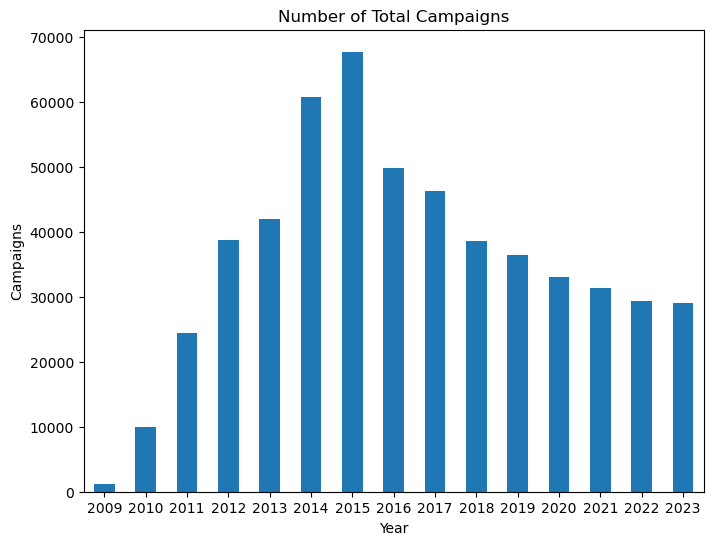

In [12]:
campaigns_by_yr = clean_data["LAUNCHED_YEAR"].value_counts().sort_index(axis=0).plot(kind= "bar", 
                    rot = 0, figsize = (8, 6), fontsize = 10, title = "Number of Total Campaigns")
campaigns_by_yr.set_xlabel("Year")
campaigns_by_yr.set_ylabel("Campaigns")
plt.show()

In the above bargraph, we can observe that the campaigns launched over time follow somewhat of a bellcurve shape. The year 2015 had the highest number of campaigns launched. While the years before 2012 had a lower amount of campaigns launched, with 2009 having having the least amount of launched campaigns. However, this correlates with the fact that Kickstarter officially launched in April 2009. 

**Bargraph of Number of Successful Campaigns Launched per Year**

We then wanted to explore if successful projects would follow a similar trend and plotted the year the Kickstarter campaign was launched versus the number of successful Kickstarter campaigns in that year.

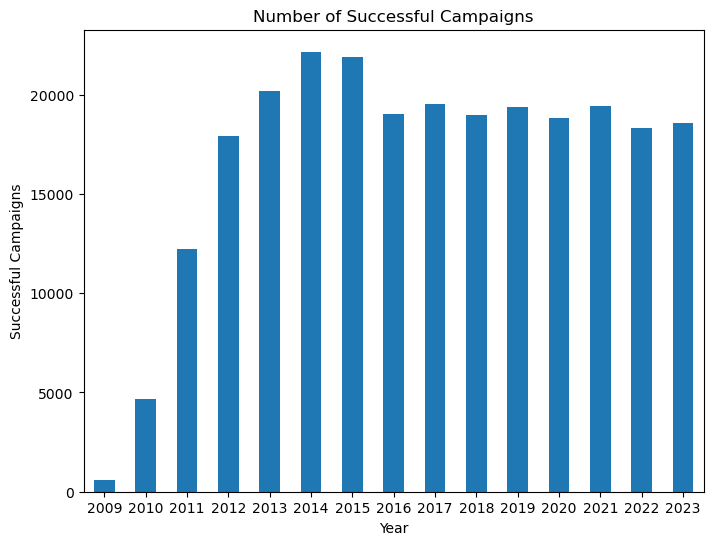

In [13]:
success_campaigns_by_yr = success_proj["LAUNCHED_YEAR"].value_counts().sort_index(axis=0).plot(kind= "bar", 
                        rot = 0, figsize = (8, 6), fontsize = 10, title = "Number of Successful Campaigns")
success_campaigns_by_yr.set_xlabel("Year")
success_campaigns_by_yr.set_ylabel("Successful Campaigns")
plt.show()

Interestingly, the number of successful campaigns showed a more consistent trend than that of the total successful and failed campaigns in the dataset. The highest number of successful campaigns was in 2014. 

### **Campaign Goal vs Backers**

We want to visualize the relationship between the campaign goal set by successful projects and the number of backers for those projects.

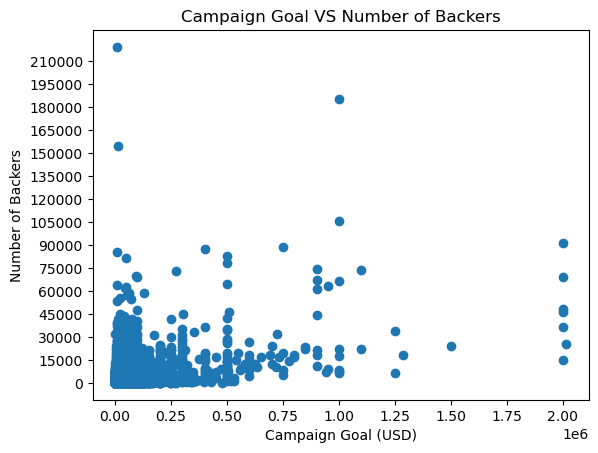

In [14]:
plt.scatter(success_proj["GOAL_IN_USD"], success_proj["BACKERS_COUNT"])
plt.title("Campaign Goal VS Number of Backers")
plt.xlabel("Campaign Goal (USD)")
plt.ylabel("Number of Backers")
plt.yticks(np.arange(0,max(success_proj["BACKERS_COUNT"]), step=15000))
plt.show()

In [15]:
backers_goal_pscore = success_proj["GOAL_IN_USD"].corr(success_proj["BACKERS_COUNT"], 
                                                       method = "pearson")
backers_goal_sscore = success_proj["GOAL_IN_USD"].corr(success_proj["BACKERS_COUNT"], 
                                                       method = "spearman")
print(f"Pearson Correlation: {np.round(backers_goal_pscore, 2)}")
print(f"Spearman Correlation : {np.round(backers_goal_sscore, 2)}")

Pearson Correlation: 0.45
Spearman Correlation : 0.64


The Pearson correlation score is 0.45 while the Spearman correlation score of 0.64 which indicates that there may be large outliers that impact the Pearson correlation. However, this information does not indicate anything about the amount that each backer has pledged to the Kickstarter campaigns. Since the spearman correlation is different than the pearson correlation, we know that the relationship between the two variables, campaign goal and number of backers is not linear.

We wanted to transform the data to perform a Linear Regression on the data to observe the relationship between campaign goal for sucessful projects and the number of backers that supported the project.

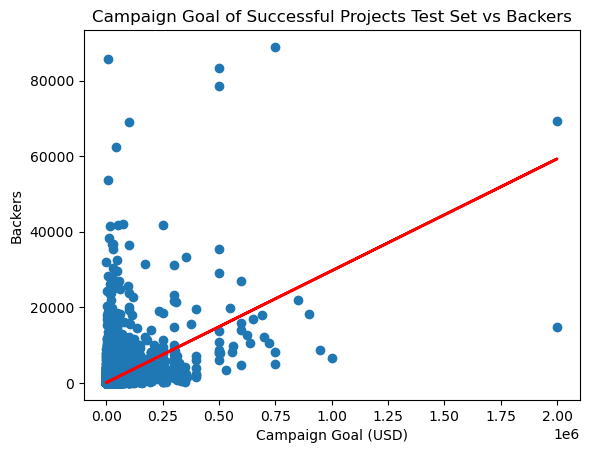

The model's slope is: 0.03
The model's intercept is: 60.52


In [16]:
X = success_proj[["GOAL_IN_USD"]]
y = success_proj["BACKERS_COUNT"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

plt.scatter(X_test, y_test)
plt.plot(X_test, y_pred, color='red', linewidth=2)
plt.xlabel("Campaign Goal (USD)")
plt.ylabel("Backers")
plt.title("Campaign Goal of Successful Projects Test Set vs Backers")
plt.show()

slope = np.round(model.coef_[0], 2)
print(f"The model's slope is: {slope}")
intercept = np.round(model.intercept_, 2)
print(f"The model's intercept is: {intercept}")

In order to see if the data needed to be transformed, we created a residual plot of the predicted number of backers to see if the data was heteroskedastistic or not. 

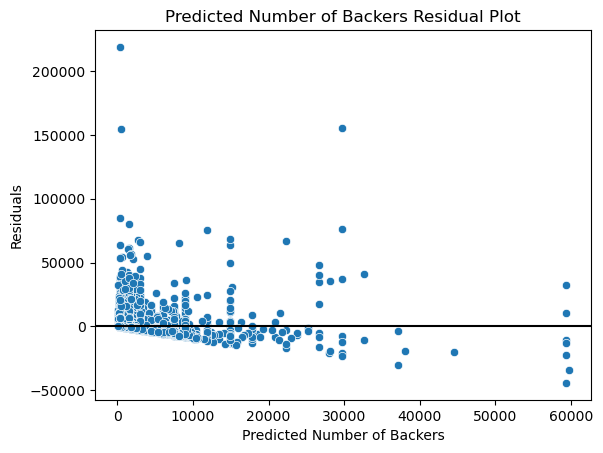

In [17]:
goal_predictions = model.predict(success_proj[["GOAL_IN_USD"]])
goal_residuals = success_proj["BACKERS_COUNT"] - goal_predictions
sns.scatterplot(x = goal_predictions, y = goal_residuals, marker = "o")
plt.xlabel("Predicted Number of Backers")
plt.ylabel("Residuals")
plt.title("Predicted Number of Backers Residual Plot")
plt.axhline(y=0, color = "black")
plt.show()


c:\Users\lovet\anaconda3\envs\info2950\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\lovet\anaconda3\envs\info2950\Lib\site-packages\numpy\lib\function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


Pearson Correlation :nan
Spearman Correlation :0.64


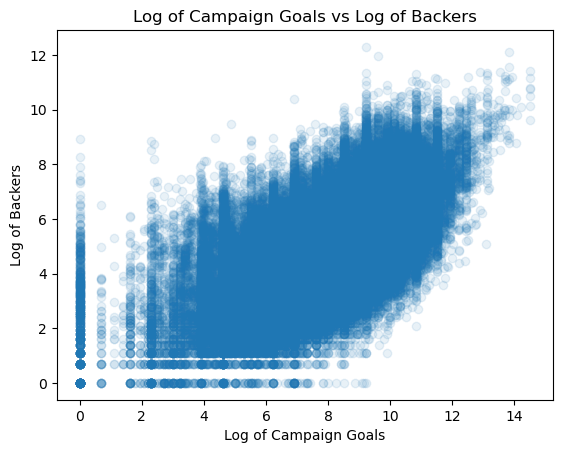

In [18]:
plt.scatter(np.log(success_proj.GOAL_IN_USD), np.log(success_proj.BACKERS_COUNT), 
            alpha = 0.1)
plt.xlabel("Log of Campaign Goals")
plt.ylabel("Log of Backers")
plt.title("Log of Campaign Goals vs Log of Backers")
log_pscore = np.log(success_proj["GOAL_IN_USD"]).corr(np.log(success_proj["BACKERS_COUNT"]), 
                                                       method = "pearson")
log_sscore = np.log(success_proj["GOAL_IN_USD"]).corr(np.log(success_proj["BACKERS_COUNT"]), 
                                                       method = "spearman")
print(f"Pearson Correlation :{np.round(log_pscore, 2)}")
print(f"Spearman Correlation :{np.round(log_sscore, 2)}")

We wanted to transform the data to perform a Linear Regression on the data to observe the relationship between backers and campaign goal for sucessful projects

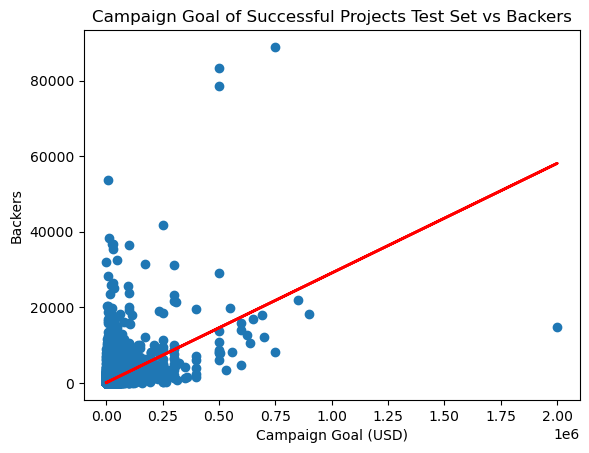

The model's slope is: 0.03
The model's intercept is: 66.18


In [19]:
X = success_proj[["GOAL_IN_USD"]]
y = success_proj["BACKERS_COUNT"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

plt.scatter(X_test, y_test)
plt.plot(X_test, y_pred, color='red', linewidth=2)
plt.xlabel("Campaign Goal (USD)")
plt.ylabel("Backers")
plt.title("Campaign Goal of Successful Projects Test Set vs Backers")
plt.show()

slope = np.round(model.coef_[0], 2)
print(f"The model's slope is: {slope}")
intercept = np.round(model.intercept_, 2)
print(f"The model's intercept is: {intercept}")

The Pearson correlation score is 0.45 while the Spearman correlation score of 0.64 which indicates that there may be large outliers that impact the Pearson correlation. However, this information does not indicate anything about the amount that each backer has pledged to the Kickstarter campaigns. 

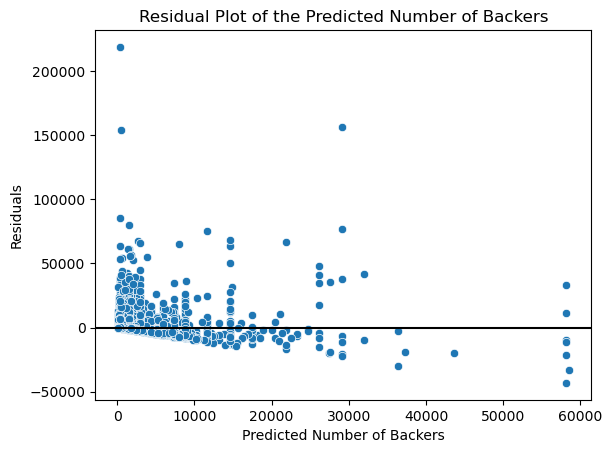

In [20]:
goal_predictions = model.predict(success_proj[["GOAL_IN_USD"]])
goal_residuals = success_proj["BACKERS_COUNT"] - goal_predictions
sns.scatterplot(x = goal_predictions, y = goal_residuals, marker = "o")
plt.xlabel("Predicted Number of Backers")
plt.ylabel("Residuals")
plt.title("Residual Plot of the Predicted Number of Backers")
plt.axhline(y=0, color = "black")
plt.show()

### **Categories vs Success**

We want to analyze the relationship between the category and the number of successful projects to determine if there are certain categories that lead to more successful campaigns. 

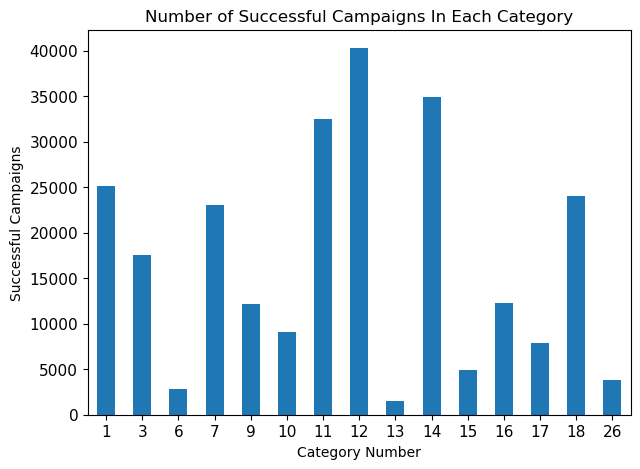

In [21]:
category_success = success_proj["CATEGORY"].value_counts().sort_index(axis=0).plot(kind= "bar", 
                    rot = 0, figsize = (7, 5), fontsize = 11, 
                    title = "Number of Successful Campaigns In Each Category")
category_success.set_xlabel("Category Number")
category_success.set_ylabel("Successful Campaigns")
plt.show()

The following values for the keys are taken from the PDF provided from the original dataset: 

1: Art, 3: Comics, 6: Dance, 7: Design, 9: Fashion, 10: Food, 11: Film & Video, 12: Games, 13: Journalism, 14: Music, 15: Photography, 16: Technology, 17: Theater, 18: Publishing, 26: Crafts

This bargraph depicts that the category with the greatest number of successful campaigns is category 12 (Games), while the category with the least number of successful campaigns is category 13 (Journalism). 

We wanted to analyze the relationship between categories and the project's campaign goals (in USD) for all successful projects, to see which categories
had the higher goals than the others, and whether it's a combination of categories and goals that influenced success, or perhaps one influenced the other.
when we run regressions later on Category vs Success and Goals vs Success, we'll take into account which categories has the highest/lowest goals to watch 
out for collinearity of inputs. 

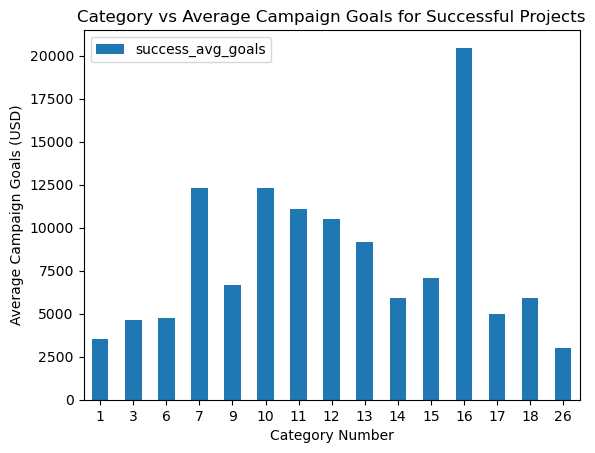

In [22]:
categories_goals_success = duckdb.sql("""SELECT CATEGORY, Avg(GOAL_IN_USD) 
                                      AS success_avg_goals FROM success_proj GROUP BY CATEGORY""").df()
categories_goals_success = categories_goals_success.sort_values("CATEGORY")
categories_goals_success.plot.bar(x = 'CATEGORY', y = 'success_avg_goals', rot =0)
plt.xlabel("Category Number")
plt.ylabel("Average Campaign Goals (USD)")
plt.title("Category vs Average Campaign Goals for Successful Projects")
plt.show()

The category with the highest average campaign goal is category 16. Interestingly, even though this has the highest average campaign goal, this category does not have the highest success rate which can be seen in the previous barplot. 

We want to analyze the relationship between categories and the project's Campaign Goals (in USD) for failed projects, so we can compare with the successful projects.

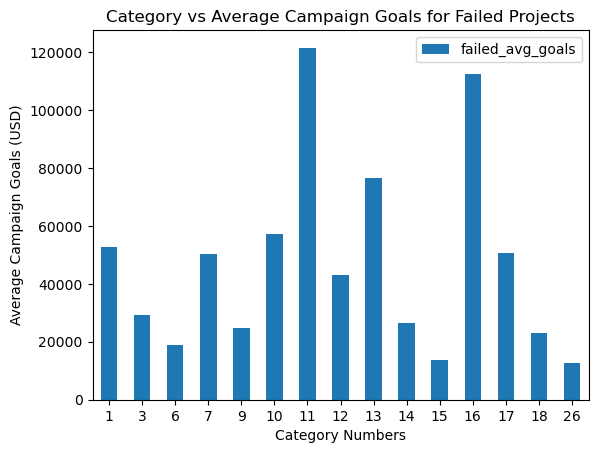

In [23]:
categories_goals_failed = duckdb.sql("""SELECT CATEGORY, Avg(GOAL_IN_USD) 
                                     AS failed_avg_goals FROM failed_proj GROUP BY CATEGORY""").df()
categories_goals_failed = categories_goals_failed.sort_values("CATEGORY")
categories_goals_failed.plot.bar(x = 'CATEGORY', y = 'failed_avg_goals', rot =0)
plt.xlabel("Category Numbers")
plt.ylabel("Average Campaign Goals (USD)")
plt.title("Category vs Average Campaign Goals for Failed Projects")
plt.show()

### **Currency vs Success**

We created a new dataframe named 'currency_success_df' to better understand the project's currency, number of successful projects for each respective currency, the total number of projects for each respective currency, to calculate the success rate for projects of each respective currency.

We also calculated the total number of different original currencies there were, which was 15. We also calculated the average success rate across all currencies. 

In [24]:
currency_success_df = duckdb.sql("""
SELECT 
    PROJECT_CURRENCY AS project_currency,
    SUM(CASE WHEN STATE = 'successful' THEN 1 END) AS num_successful,
    COUNT(*) AS total_projects,
    CASE 
        WHEN COUNT(*) = 0 THEN 0
        ELSE COUNT(CASE WHEN STATE = 'successful' THEN 1 END) * 1.0 / COUNT(*)
    END AS success_rate
FROM 
    clean_data 
GROUP BY 
    PROJECT_CURRENCY
ORDER BY num_successful DESC
""").df()

num_diff_currencies = len(currency_success_df)
print(f"The number of different currencies is: {num_diff_currencies}")

avg_success_rate = currency_success_df['success_rate'].mean()
print(f"The average success rate of all currencies is {avg_success_rate:.2f}")

currency_success_df.iloc[:5]

The number of different currencies is: 15
The average success rate of all currencies is 0.46


,project_currency,num_successful,total_projects,success_rate
0,USD,178334.0,381263,0.467745
1,GBP,28143.0,55268,0.509210
2,EUR,17256.0,41487,0.415938
3,CAD,10908.0,23889,0.456612
4,AUD,5162.0,12353,0.417874


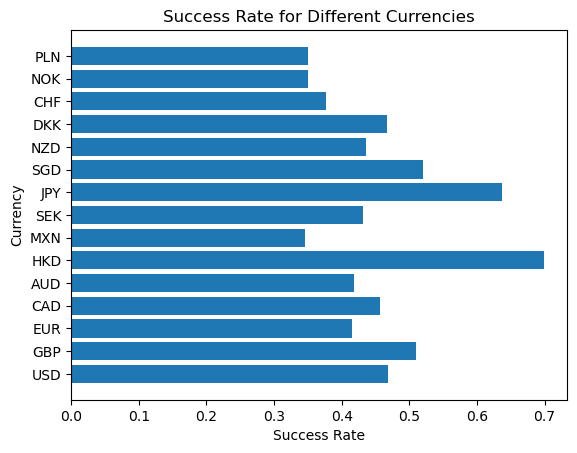

In [25]:
currency_success = plt.barh(currency_success_df["project_currency"], 
                            currency_success_df["success_rate"])
plt.xlabel("Success Rate")
plt.ylabel("Currency")
plt.title("Success Rate for Different Currencies")
plt.show()

It appears that campaigns listed with the currency HKD has the highest success rate of the Kickstarter campaigns, while campaigns with the currency MXN has the lowest success rate. 

### **Logistc Regression Models**

We then made the categorical variable, STATE, into a binary variable so we can run logit on it with other variables later to find possible predictors for the success and/or failure of a project.

In [26]:
clean_data["STATE"] = (clean_data["STATE"] =="successful").astype(int)

We ran a regression to predict the relationship between the surplus raised from the campaign and the STATE of a project (successful vs failed). We calculated that there are 5687 projects that had a successful state of 1 with a surplus of 0 USD and there are 8 projects that had a failed state of 0 with a surplus of 0 USD.

At first, we saw that the data was concentrated mainly at x = 0 which implied that there were many projects that had a surplus of 0 and were successful. To check this, we ran a SQL query that counted the number of projects that had a surplus of 0 and split it into those whose STATE was 0 and those whose STATE was 1. We calculated that there are 5687 projects that had a successful state of 1 with a surplus of 0 USD and there are 8 projects that had a failed state of 0 with a surplus of 0 USD.

However, the inconsistency of this result made us confused as to how to proceed. We used the attributes, PLEDGED_IN_USD and GOAL_IN_USD to calculate the surplus_raised since it was standardized across all possible currencies, however, we noticed by printing out the 8 projects whose STATE = 0 (failed) and whose surplus = 0, that there were rows with inconsistencies between the PLEDGED_IN_USD and PLEDGED_IN_ORIGINAL_CURRENCY columns matching up with their respective GOAL_IN_USD and GOAL_IN_ORIGINAL_CURRENCY columns. However, there were also rows where both the pledged amount and goal amount in both USD and the orignal currencies matched up, but the STATE was still = 0 which does not logically make sense. There may be an issue with integer vs float summation/rounding which would explain why STATE = 0 even though mathmatically, it makes more sense for STATE = 1.

To analyze the overall generalizabillity of our model, we did a train test split 70%-30% on our data. We trained our model on 70% of our data, then used the model to predict values in our test set, and graphed a scatterplot of the prediction values to see the results for now. We will use evaluation metrics to compare the results of the model on preidcting values for the trained data vs test data to see if it can be generalizable for both. 

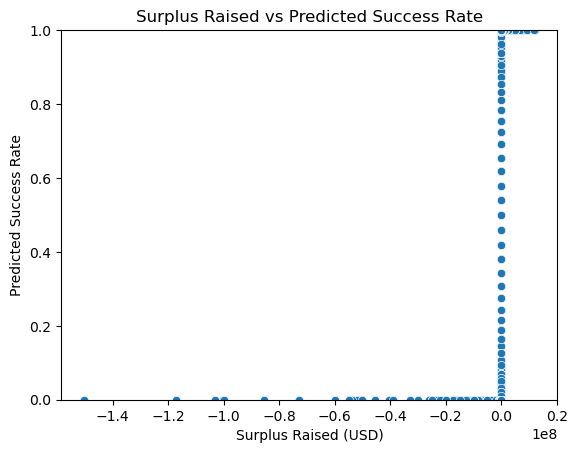

   STATE  project_count
0      1           5687
1      0              8


,CASEID,PID,CATEGORY,PROJECT_PAGE_LOCATION_NAME,PROJECT_CURRENCY,GOAL_IN_ORIGINAL_CURRENCY,PLEDGED_IN_ORIGINAL_CURRENCY,GOAL_IN_USD,PLEDGED_IN_USD,BACKERS_COUNT,LAUNCHED_DATE,DEADLINE_DATE,STATE,time_difference_days,LAUNCHED_YEAR,DEADLINE_YEAR,surplus_raised
0,60605,790638930,11,Vancouver,USD,40000,40000,40000,40000,113,2011-07-25,2011-09-23,0,60,2011,2011,0
1,154550,818363688,17,Manhattan,USD,12000,11999,12000,12000,77,2015-11-17,2016-01-06,0,50,2015,2016,0
2,196685,812545055,6,Mexico City,MXN,10000,9999,525,525,11,2018-06-19,2018-07-23,0,34,2018,2018,0
3,310593,1695255515,17,New York,USD,3600,3600,3600,3600,30,2010-07-21,2010-08-20,0,30,2010,2010,0
4,333460,416370896,14,Nashville,USD,3000,2999,3000,3000,24,2012-07-20,2012-08-11,0,22,2012,2012,0
5,504620,1257771766,10,Cleveland,USD,10,9,10,10,1,2014-07-08,2014-08-07,0,30,2014,2014,0
6,506198,9572984,11,New York,USD,0,0,0,0,0,2012-01-25,2012-03-16,0,51,2012,2012,0
7,506199,219760504,11,Los Angeles,USD,0,0,0,0,0,2011-07-12,2011-07-19,0,7,2011,2011,0


In [27]:
clean_data["surplus_raised"] = clean_data["PLEDGED_IN_USD"] - clean_data["GOAL_IN_USD"]

X1 = clean_data[["surplus_raised"]]
y1 = clean_data["STATE"]
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.3, random_state=2950) 

surplus_train_model = LogisticRegression().fit(X_train,y_train)
surplus_train_prediction = surplus_train_model.predict_proba(X_train)
surplus_test_prediction = surplus_train_model.predict_proba(X_test)
surplus_test_success = surplus_test_prediction[:,1] 

sns.scatterplot(x = X_test["surplus_raised"], y = surplus_test_success)
plt.title("Surplus Raised vs Predicted Success Rate")
plt.xlabel("Surplus Raised (USD)")
plt.ylabel("Predicted Success Rate")
plt.ylim(0,1)
plt.show()


test_df = duckdb.sql("""SELECT STATE, COUNT(*) AS project_count
FROM clean_data WHERE surplus_raised = 0 GROUP BY STATE
ORDER BY project_count DESC""").df()

print(test_df)

zero_state_df = duckdb.sql("""SELECT * FROM clean_data
WHERE STATE = 0 AND surplus_raised = 0""").df()

zero_state_df.iloc[:8]

We run a regression on the length of time of a project and its probability of success. We hypothesize that a project that has been running longer may have more time to promote and find backers, and so might have a higher probability of success. However, when we ran the model on the total data and plotted the predictions, we found an unusually high probability on projects with a zero-day time difference. We did a train test splut 70%-30% on this data as well, and will do evaluation metrics on this as well. However, when we searched for the number of successful projects with a zero-day time difference (meaning they were launched on the deadline date), there were only two successful ones. We are unsure on what went wrong with our logistic regression, or if there were any errors in our data beforehand, so are uncertain on how to proceed from here. 

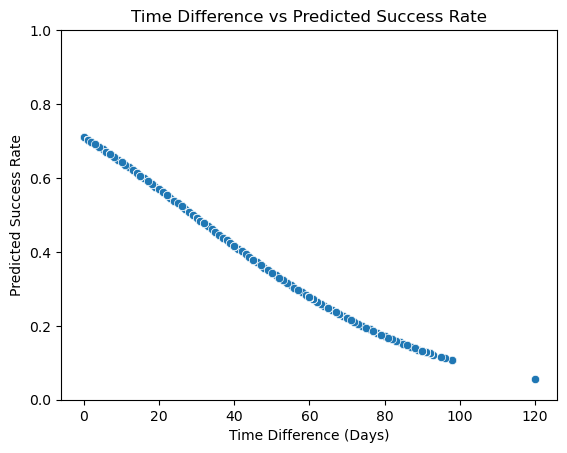

In [28]:
X1 = pd.DataFrame(clean_data["time_difference_days"])
y1 = pd.Series(clean_data["STATE"])
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3) 

time_model = LogisticRegression().fit(X1_train,y1_train)
time_hat_prediction = time_model.predict_proba(X1_train)
time_test_prediction = time_model.predict_proba(X1_test)

#run Logistic Regression on total data to visualize predictions
time_model = LogisticRegression().fit(X1,y1)
time_prediction = time_model.predict_proba(X1)
time_success = time_prediction[:,1]
clean_data["time_success_prediction"] = time_success
sns.scatterplot(clean_data, x = "time_difference_days", y = "time_success_prediction")
plt.title("Time Difference vs Predicted Success Rate")
plt.xlabel("Time Difference (Days)")
plt.ylabel("Predicted Success Rate")
plt.ylim(0,1)
plt.show()

## **Correlation Heat Map**

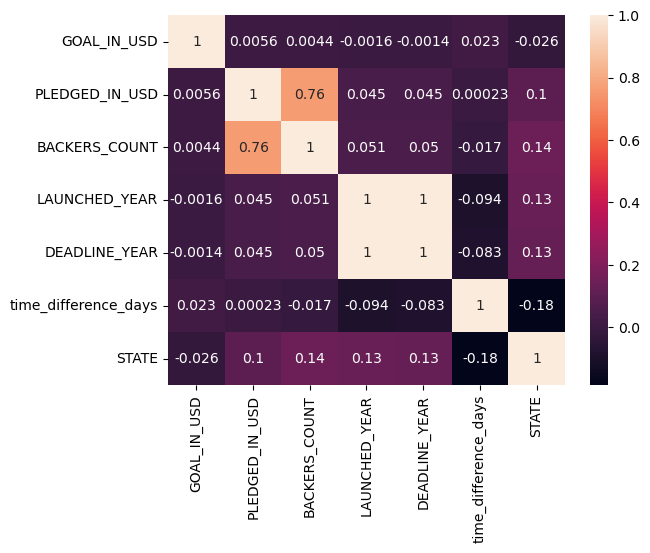

In [29]:
corr_data = clean_data[["GOAL_IN_USD", "PLEDGED_IN_USD","BACKERS_COUNT",
                        "LAUNCHED_YEAR","DEADLINE_YEAR","time_difference_days","STATE"]]
corr = corr_data.corr()
sns.heatmap(corr, annot = True)
plt.show()

## **Data Limitations**

There are several limitations to our research as the data is limited to the Kickstarter public dataset. Since many variables on our public data tsv are restricted, including the project description, we can’t draw a clear relationship between what exactly about a specific category that leads to it being more or less successful than other categories. This affects the meaning of our results because there are unclear causes on why successful a project is successful, as we're only relying on the labels on the Categories of our cleaned data. We can answer our research question on which categories are successful, but can't expand further on the reasons why. 

The cleaned dataset used was also limited as we only used a portion of all the Kickstarter projects. We decided to remove projects that did not have a STATE of success or failed, which were cancelled and suspended campaigns. This indicates that our data analysis is based on solely on success or failed projects, and does not take into account cancelled or suspended campaigns. This binary view on the data can exclude projects that were close to succeeding or had a high probability of succeeding but were dropped last minute. Had those rows been labelled as successful, we could’ve used them to either enforce or counter our results. 

Another limitation in our collected data is that even though we can say that one factor is more directly related to success, there may be outside confounding variables (such as previous popularity of project creator, social media handles, advertising/promotion) that can influence each factor. So, we might not be finding the root causes of successes, and can only base our predictions on the factors given to us.

## **Questions For Reviewers**

1. In the scatterplot generated from the surplus_model based on a Logistic_Regression, do you recommend normalizing/maybe transforming the x-axis using a linear log transformation to make x=0 more readable? Right now, there is a heavy concentration of data on x=0 and it seems like there are many projects that have a surplus of $0 in USD even though we know from limiting the x-axis to 0 to 10,000 that that is not the case.
- In addition, are we able to properly predict the success rate of a project if the value on the y-axis (surplus) can be both negative and positive? How would you suggest we handle this case (spliting up the data into successful and failed projects?)

2. When we ran a logistic regression to predict the relationship between the surplus raised from the campaign and the STATE of a project (successful vs failed). We calculated that there are 5687 projects that had a successful state of 1 with a surplus of 0 USD and there are 8 projects that had a failed state of 0 with a surplus of 0 USD.

- ISSUES: When we printed out these 8 projects, we noticed there were rows with inconsistencies between the PLEDGED_IN_USD and PLEDGED_IN_ORIGINAL_CURRENCY columns matching up with their respective GOAL_IN_USD and GOAL_IN_ORIGINAL_CURRENCY columns. However, there were also rows where both the pledged amount and goal amount in both USD and the orignal currencies matched up, but the STATE was still = 0 which does not logically make sense. 

- We assumed that the first issue involved integer vs float summation/rounding which would explain why STATE = 0 if we calculated with GOAL_IN_ORIGINAL_CURRENCY and PLEDGED_IN_ORIGINAL_CURRENCY, but we selectively chose to calculate with the values converted to USD to standardize our resulting scatterplots' axes for all currencies. 
- How should we handle this data? How should we scale the x-axis so we can see the values that look like they are forming a vertical line on x=0?

3. Currently in our data, we use different ways to measure success, using number of successful projects and the STATE column of successful or failed. We also changed the STATE column into dummy variables for success and failed projects, and used a calculation to find success rate from successful over total projects for the currency analysis. Would this give us valid results if we did it this way?

4. We found it strange that for the time difference vs success regression that a time difference of zero has the highest probability of success. We checked the data and found that there are two successful projects with a time difference of zero, so we're wondering how that impacted the data. Did something occur within the logistic regression that lead to the graph looking this way? How should we fix this error?

5. How do we handle 'RunTimeError of DivideByZero Warning' when doing Log transformations? Should we consider all datapoints that are greater than 0 to prevent this, or should we still include the data causing the error?"